In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def smoothen(waypoints):
    optimumpointlist = []
    i = 0
    range_factor = 6
    avg_factor = 2 * range_factor + 1
    num_of_waypoints = len(waypoints)

    for point in waypoints:
        counter = 0
        estimated_x_cord = point[0]
        estimated_y_cord = point[1]
        while counter < range_factor:
            estimated_x_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][0]
            estimated_x_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][0]

            estimated_y_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][1]
            estimated_y_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][1]
            counter += 1

        estimated_x_cord = estimated_x_cord / avg_factor
        estimated_y_cord = estimated_y_cord / avg_factor


        optimumpointlist.append(np.array( (estimated_x_cord, estimated_y_cord) ))

        i += 1
    return np.array(optimumpointlist)

In [3]:
def calc_distance(prev_point, next_point):
    delta_x = next_point[0] - prev_point[0]
    delta_y = next_point[1] - prev_point[1]
    return math.hypot(delta_x, delta_y)

def smooth_central_line(center_line, max_offset, pp=0.10, p=0.05, c=0.70, n=0.05, nn=0.10, iterations=72, skip_step=1):
    if max_offset < 0.0001:
        return center_line
    if skip_step < 1:
        skip_step = 1
    smoothed_line = center_line
    for i in range(0, iterations):
        smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
    return smoothed_line


def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
    length = len(center_line)
    new_line = [[0.0 for _ in range(2)] for _ in range(length)]
    for i in range(0, length):
        wpp = smoothed_line[(i - 2 * skip_step + length) % length]
        wp = smoothed_line[(i - skip_step + length) % length]
        wc = smoothed_line[i]
        wn = smoothed_line[(i + skip_step) % length]
        wnn = smoothed_line[(i + 2 * skip_step) % length]
        new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
        new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
        while calc_distance(new_line[i], center_line[i]) >= max_offset:
            new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
            new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
    return new_line

In [4]:
TRACK_NAME = 'C:/Users/suraj/projects/deepracer24/2022_may_open_ccw.npy'

# Load the center, inner, outer waypoints
waypoints = np.load(TRACK_NAME)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [5]:
# smooth_path = smoothen(center_line)
smooth_path = smooth_central_line( center_line, 1.066*0.60*0.5,skip_step=1 )
smooth_path = np.array( [ np.array(point) for point in smooth_path ] )
# smooth_path = up_sample(smooth_path, 10)

In [6]:
center_line[:10]

array([[5.04771315, 0.73385354],
       [5.04770565, 0.86385354],
       [5.04769568, 0.99385354],
       [5.04768252, 1.1654985 ],
       [5.04763508, 1.46714252],
       [5.04763794, 1.76878798],
       [5.04779196, 2.07043898],
       [5.0475924 , 2.37207794],
       [5.04653549, 2.67368758],
       [5.047997  , 2.97538257]])

In [7]:
import pandas as pd

data = pd.read_csv('C:/Users/suraj/projects/deepracer24/deepracer-log-guru/022/training_data.csv')
status_col = 'episode_status' if 'episode_status' in data.columns else 'status'
data = data[data[status_col]=='in_progress']
data.rename(columns={'X':'x', 'Y':'y', 'yaw':'heading', 'steer':'steering_angle', 'throttle':'speed', 'closest_waypoint': 'closest_waypoints'}, inplace=True)
data['is_offtrack'] = False
data['is_crashed'] = False
data = data[['x', 'y', 'heading', 'speed', 'steering_angle', 'progress', 'closest_waypoints', 'steps', 'is_offtrack', 'is_crashed']]
data.shape

(10537, 10)

In [29]:
row_number = 8008
params = data.iloc[row_number].to_dict()
params['closest_waypoints'] = [ params['closest_waypoints'], params['closest_waypoints']+1 ]
# params['heading'] = 90
params['steering_angle'] = 10
# params['speed'] = 2
params['x'] = params['x']/100.0
params['y'] = params['y']/100.0 - 0.39

print(params)

params['waypoints'] = list( [list(point) for point in center_line] )

{'x': 1.3544, 'y': 5.103200000000001, 'heading': 153.5336, 'speed': 1.25, 'steering_angle': 10, 'progress': 0.9238, 'closest_waypoints': [26, 27], 'steps': 9, 'is_offtrack': False, 'is_crashed': False}


In [30]:
from reward_function import reward_function, get_heading_reward, is_higher_speed_favorable, following_smooth_path_reward, get_steering_reward

print( 'total rewards: ', reward_function(params) )
print( 'heading_reward', get_heading_reward(params) ) # 0.01 to 10
print('steering_angle_factor: ', get_steering_reward(params))
print( 'speed_reward', is_higher_speed_favorable(params) ) # 1 to 10
print( 'on_smooth_track_reward', following_smooth_path_reward(params) ) # 0 to 10

total rewards:  11.210954236320342
heading_reward 5.45446887292917
steering_angle_factor:  7.003676667373194
speed_reward 0.004760441290222697
on_smooth_track_reward 0.8866086166785352


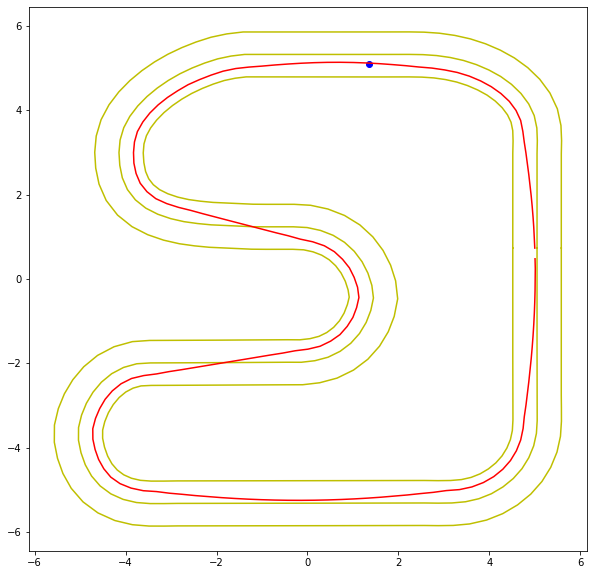

In [28]:
# plt.scatter(smooth_path[75][0], smooth_path[75][1], c = 'k')
# plt.scatter(smooth_path[76][0], smooth_path[76][1], c = 'y')
plt.scatter(params['x'], params['y'], c = 'b')
plt.plot(center_line[:,0], center_line[:,1], label = 'outer_border', c = 'y')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
# plt.scatter(1.1, -0.91, c = 'b')
# plt.scatter(0.87, -1.1, c = 'b')
# plt.scatter(0.7, -1.3, c = 'b')

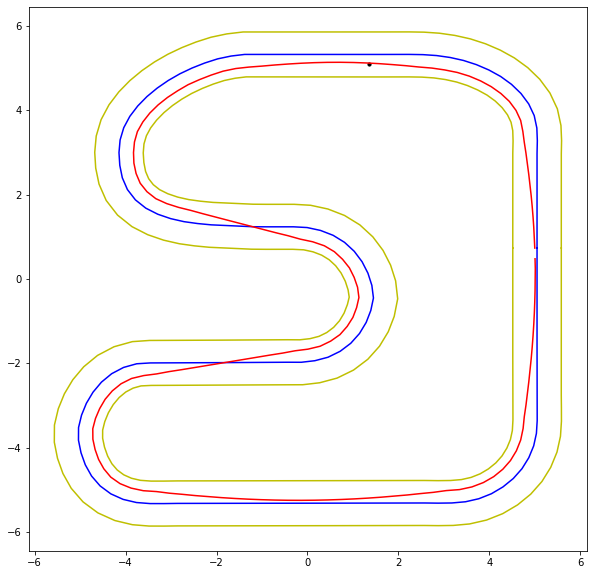

In [24]:
plt.plot(center_line[:,0], center_line[:,1], label = 'center_line', c = 'b')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'inner_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
plt.scatter(params['x'], params['y'], s = 10, c = 'k')
# plt.plot(smooth_path[10:12,0], smooth_path[10:12,1], label = 'smooth_path_subsection', c = 'k')
# for i in range(0, 21):
#     plt.scatter( center_line[i][0], center_line[i][1], label = 'cl'.format(i), s = 10, c = 'k' )
#     plt.scatter( smooth_path[i][0], smooth_path[i][1], label = 'sl'.format(i), s = 10, c = 'r' )
#plt.scatter( center_line[10][0]+0.4, center_line[10][1], label = 'random_point', s = 10, c = 'k' )
# plt.legend()
plt.show()

In [32]:
p1 = smooth_path[10][0], smooth_path[10][1]
p2 = smooth_path[11][0], smooth_path[11][1]
p3 = center_line[10][0]+4, center_line[10][1]
# distanceFromLine( p1, p2, p3 )

In [33]:
# Calculate distance between current point and closest point on line between prev_point and next_point
def calc_distance_from_line(curr_point, prev_point, next_point):
    distance_cp_to_pp = calc_distance(curr_point, prev_point)  # b
    distance_cp_to_np = calc_distance(curr_point, next_point)  # a
    distance_pp_to_np = calc_distance(prev_point, next_point)  # c
    # cos A = (b^2 + c^2 - a^2) / 2bc
    angle_pp = math.acos((distance_cp_to_pp * distance_cp_to_pp + distance_pp_to_np * distance_pp_to_np
                          - distance_cp_to_np * distance_cp_to_np) / (2 * distance_cp_to_pp * distance_pp_to_np))
    # b / sin(Pi/2) = d / sin(A)
    return distance_cp_to_pp * math.sin(angle_pp)

In [34]:
calc_distance_from_line( p3, p1, p2 )

4.259567488559164

In [35]:
def optimalSpeed():
    """ no high difference in heading
        output range: 1 - 10
    """
    tp, angleChange = get_turn_points(smooth_path)
    tp = list([list(p) for p in tp])
    optimal_speeds = []
    max_speed = 3.8
    min_speed = 1.25
    for i, point in enumerate(smooth_path[:-1]):
        point = list(smooth_path[i+1])
        turn_angle = 0 if not point in tp else angleChange[ tp.index(point) ]
        optimal_speed = max_speed - ( turn_angle / max(angleChange)) * (max_speed - min_speed)
        optimal_speeds.append( optimal_speed )
    return optimal_speeds, tp, angleChange

In [36]:
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r

def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]

def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead

In [37]:
# optimal_velocity = optimal_velocity(smooth_path, 1.25, 3.8, 5)

Constant multiple for optimal speed: 1.4517434175405106


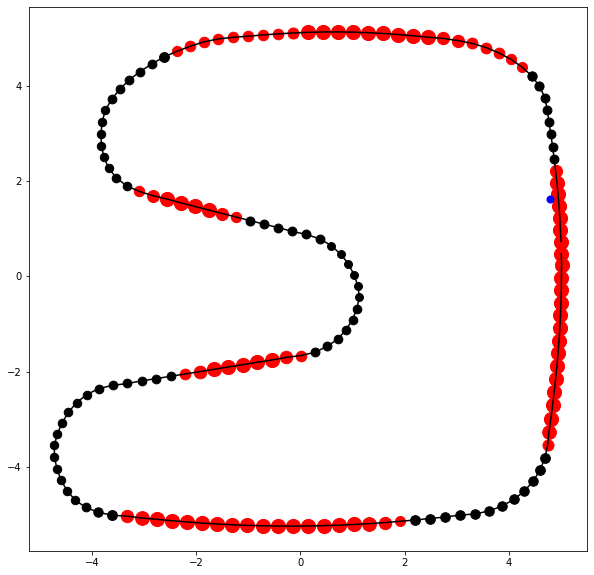

In [42]:
# optimal_speeds, tp, angleChange = optimalSpeed()
optimal_velocity_ = optimal_velocity(smooth_path, 1.25, 4.0, 5 )
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'k')
for i, point in enumerate(smooth_path):
    point = list(point)
    # if point in tp:        
    plt.scatter(point[0], point[1], s = optimal_velocity_[i]*50, c = 'k' if optimal_velocity_[i]<2 else 'r')
        # plt.scatter(point[0], point[1], s = angleChange[ tp.index(point) ]*10, c = 'r')
plt.scatter(params['x'], params['y'], c = 'b', s=50 )
plt.show()

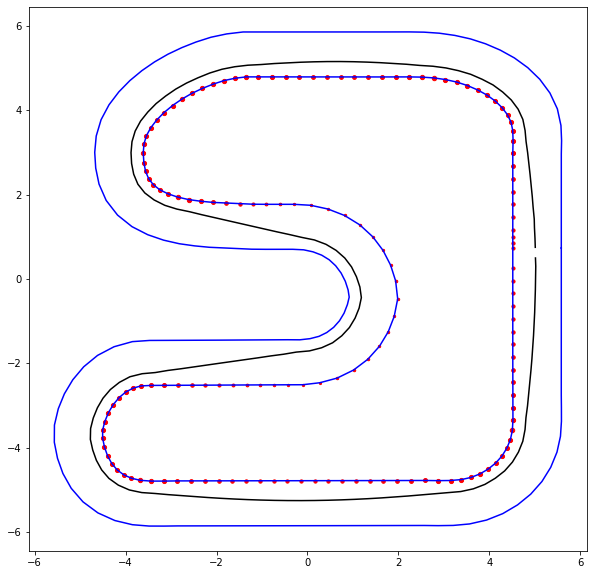

In [663]:
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'b')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'outer_border', c = 'b')
dr = []
for i, point in enumerate(inner_border[:-2]):
    reward = distanceReward( smooth_path[i+1], smooth_path[i+2], point )
    dr.append(reward)
    plt.scatter(point[0], point[1], s = reward*5, c = 'r')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'k')
plt.show()

In [665]:
print( min(dr) )
print( max(dr) )

0.9371468735192957
3.9659172670737433


In [666]:
distanceFromLine(p1, p2, p3)

4.234038132293446

In [667]:
cl = [ list(p) for p in center_line ]

In [668]:
cl.index([5.047791957855225, 2.0704389810562134])

ValueError: [5.047791957855225, 2.0704389810562134] is not in list

In [669]:
def calculate_angle(p1, p2, p3):
    # Calculate the angle between three points p1, p2, p3
    angle = math.degrees(
        math.atan2(p3[1] - p2[1], p3[0] - p2[0]) - math.atan2(p1[1] - p2[1], p1[0] - p2[0])
    )
    return angle % 360

def shape_complexity(coordinates):
    num_angles = len(coordinates) - 2
    total_angle_sum = 0

    for i in range(num_angles):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i + 1]
        x3, y3 = coordinates[i + 2]

        angle = calculate_angle(x1, y1, x2, y2, x3, y3)
        total_angle_sum += angle

    # Calculate the average angle to assess shape complexity
    average_angle = total_angle_sum / num_angles

    # Higher average angle indicates a more complex shape
    return average_angle

In [670]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def fit_in_range( x, lower = -100, upper = 100 ):
    return lower + (sigmoid(x) - 0) * (upper - lower) / (1 - 0)

In [671]:
def angle(p1, p2):
    """
    """
    dy = p2[1]-p1[1]
    dx = p2[0]-p1[0]
    return math.degrees(math.atan2(dy,dx))

In [672]:
def diffrentiate( signal ):
    x = [p[0] for p in signal]
    y = [p[1] for p in signal]
    dy = [y[i+1]-y[i] for i in range(len(y)-1)]
    dx = [x[i+1]-x[i] for i in range(len(x)-1)]
    dy_by_dx = [ dy/dx for dy, dx in zip(dy, dx) ]
    return [ (x, y) for x,y in zip( x[:len(dy_by_dx)], dy_by_dx ) ]

In [713]:
def get_turn_points(coordinates):
    turn_points = []
    angle_change = []
    window_size = 8
    threshold_angle = 4.5  # Set a threshold angle to determine a significant turn

    for i in range(len(coordinates) - window_size + 1):
        window = coordinates[i : i + window_size]
        angles = [
            calculate_angle(window[j], window[j + 1], window[j + 2]) for j in range(window_size - 2)
        ]
        max_angle_change = abs( max(angles) - min(angles) )
        if max_angle_change >= threshold_angle:
            turn_points.append(coordinates[i])
            angle_change.append(abs(max_angle_change))
    return turn_points, angle_change

In [674]:
def angle_between_points(first_point, second_point, third_point):
    """Calculates the angle between two line segments formed by three points."""
    first_dx = second_point[0] - first_point[0]
    first_dy = second_point[1] - first_point[1]
    third_dx = first_point[0] - third_point[0]
    third_dy = first_point[1] - third_point[1]
    angle = math.atan2(third_dy, third_dx) - math.atan2(first_dy, first_dx)
    return math.degrees(angle)

# def get_turn_points(waypoints):
#     turn_points = []
#     for i, point in enumerate(waypoints):
#         next_3 = [ waypoints[(i+1)%len(waypoints)] for i in range(3) ]
#         try:
#             angle = angle_between_points(next_3[0], next_3[1], next_3[2])
#             if abs(angle) > 180:
#                 turn_points.append(point)
#         except Exception as ex:
#             print( i, point, ex )
#     return turn_points


In [675]:
# def calculate_angle(p1, p2, p3):
#     # Calculate the angle between three points p1, p2, p3
#     angle = math.degrees(
#         math.atan2(p3[1] - p2[1], p3[0] - p2[0]) - math.atan2(p1[1] - p2[1], p1[0] - p2[0])
#     )
#     return angle % 360

def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ( ang + 360 if ang < 0 else ang )

In [676]:
getAngle((1,1), (0,0), (1,-0.5))

288.434948822922

In [677]:
tp, ac = get_turn_points(center_line[:])

In [678]:
print( min(ac) )
print( max(ac) )

4.63232589770837
13.562838677485416


In [679]:
optimal_speed = 4 - (0 / 14) * (4 - 1.5)

# Calculate reward for speed
speed_diff = abs(1.5 - optimal_speed)
reward_speed = math.exp(-0.5 * speed_diff)

print(optimal_speed)
print(speed_diff)
print(reward_speed)

4.0
2.5
0.2865047968601901


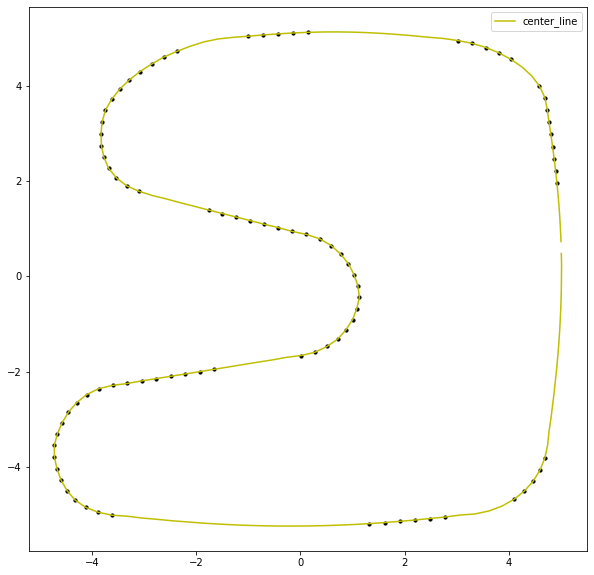

In [773]:
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'center_line', c = 'y')
# plt.plot(inner_border[:,0], inner_border[:,1], label = 'inner_border', c = 'b')
# plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'b')
# plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
# plt.plot(smooth_path[10:12,0], smooth_path[10:12,1], label = 'smooth_path_subsection', c = 'k')
# for i in range(0, 21):
#     plt.scatter( center_line[i][0], center_line[i][1], label = 'p_{}'.format(i), s = 10, c = 'k' )
#plt.scatter( center_line[10][0]+0.4, center_line[10][1], label = 'random_point', s = 10, c = 'k' )

for p in get_turn_points(smooth_path)[0]:
    plt.scatter( p[0], p[1], s = 10, c = 'k' )

plt.legend()
plt.show()

In [681]:
def normalize_reward(reward):
    sign = 1 if reward >=0 else -1
    if reward == 0:
        return 0
    if reward <=0:
        reward = 1/(1 + np.exp(-np.abs(reward)/1000) )
    if reward >=0:
        reward = (math.log2(reward)*2)/(1 + np.exp(-np.abs(reward)/100) )
    reward = reward**2
    reward = sign*(1 - reward) if sign < 0 else reward
    return reward

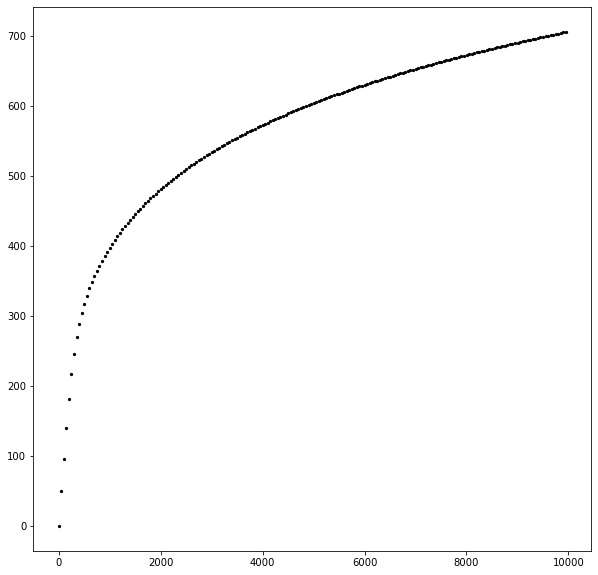

In [682]:
for x in range( 1, 10000, 50):
    plt.scatter( x, normalize_reward(x), c = 'k', s = 5 )
plt.show()

In [683]:
rewards = [2300, 1800, 161, 94, 24, -24, -94, -1800, -2300]
for r in rewards:
    print(normalize_reward(r))

498.84491207302614
467.7514403583875
149.3122504432363
88.86465619377903
26.342886640980296
-0.029227288505335736
-0.12347282063276521
-0.9508726066003852
-0.9808262321356962


In [684]:
normalize_reward(10000000000)

4414.082507040793

In [685]:
5.95**2

35.4025

In [686]:
0.95**2

0.9025

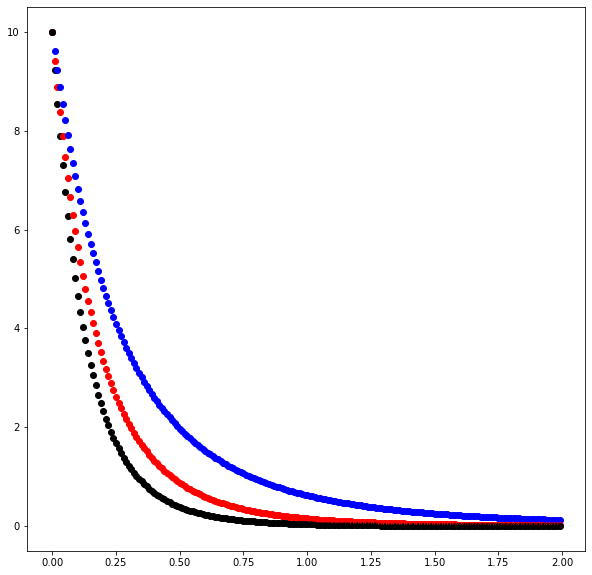

In [687]:
for d in range(0, 200):
    d = d/100
    plt.scatter( d, 10/( (1+float(d))**4 ), c = 'b' )
    plt.scatter( d, 10/( (1+float(d))**6 ), c = 'r' )
    plt.scatter( d, 10/( (1+float(d))**8 ), c = 'k' )
plt.show()

In [689]:
d = 0
prev_point = None
for point in center_line:
    if prev_point is None:
        prev_point = point
        continue
    d+=calc_distance(prev_point, point)
    prev_point = point
d

46.117797621400626

In [423]:
import math

In [430]:
direction_diff = 20

math.cos( abs(direction_diff ) * ( math.pi / 180 ) ) ** 4

0.7797282437678554

In [609]:
def calc_angle_bw_heading(p1, p2, heading):
    angle =  math.degrees(
        math.atan2(p2[1] - p1[1], p2[0] - p1[0])
    ) -  heading
    if angle < 0:
        angle = angle + 360

    if angle > 180:
        angle = angle - 360
    
    return angle

In [796]:
p1 = (0,0)
p2 = (-1, -1)
heading = 90

calc_angle_bw_heading(p1, p2, heading=heading)

135.0

In [797]:
angle =  math.degrees(
        math.atan2(p2[1] - p1[1], p2[0] - p1[0])
    )
angle

-135.0

In [622]:
print(calc_angle_bw_heading((0,0), (1, 1), 90))
print(calc_angle_bw_heading((0,0), (-1, 1), 90))
print(calc_angle_bw_heading((0,0), (-1, -1), 90))
print(calc_angle_bw_heading((0,0), (1, -1), -80))

-45.0
45.0
135.0
35.0


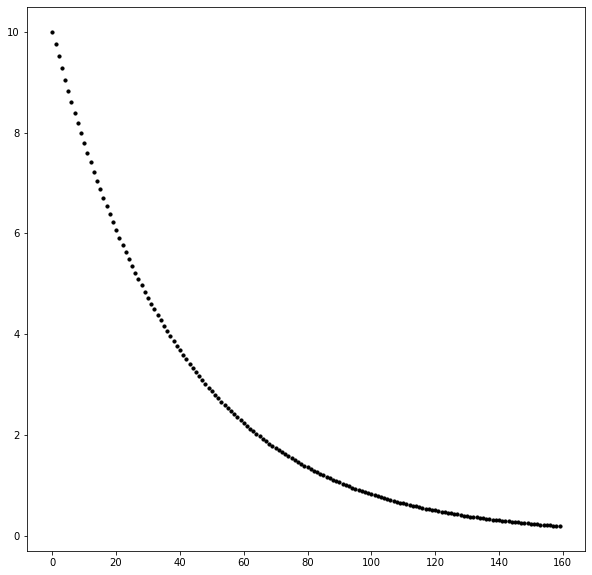

In [12]:
# sigma = (3.8-1.25)/6
for x in range(0, 160):
    plt.scatter(x, 10*math.exp(-0.5*x/20), s = 10, c = 'k')
plt.show()

In [620]:
math.exp(-0.5*((2.55**2)/sigma))

0.00047604412902226977

In [621]:
math.exp(-0.5 * 2.55)

0.27943096822140734

In [631]:
def is_steps_favorable(progress, steps):
    # if max steps = 500 then range: 0 - 100
    #############################################################################
    '''
    Example of using steps and progress
    '''
    TOTAL_NUM_STEPS = 300
    reward = 1.0

    # Give additional reward if the car pass every 100 steps faster than expected
    if steps > 0 and (steps % 100) == 0 and progress > (steps / TOTAL_NUM_STEPS) * 100 :
        reward += 10.0

    return float(reward)

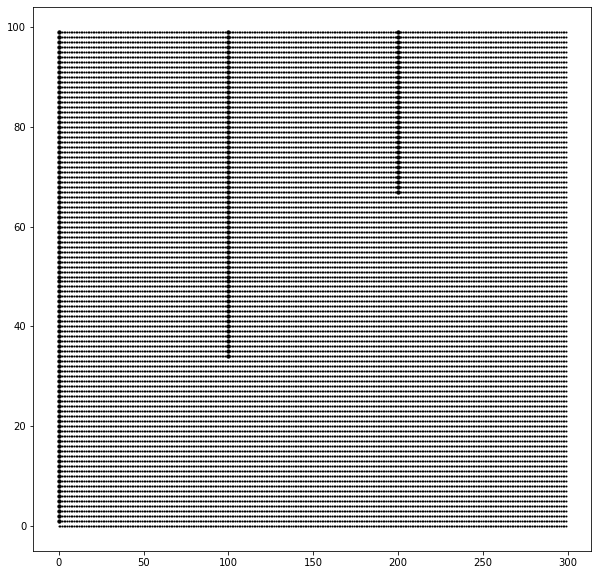

In [632]:
for p in range(0, 100):
    for s in range(0,300):
        plt.scatter(s, p, s = is_steps_favorable(p, s), c = 'k')
plt.show()

In [ ]:
def is_a_turn_coming_up( params ):
    waypoints = _get_waypoints(params)
    next_way_point = waypoints[params["closest_waypoints"][1]] #getting smooth point at the index of the closest waypoint
    tp, ac = get_turn_points( waypoints )
    if next_way_point in tp:
        return ac[ tp.index(next_way_point) ]
    return 0

In [711]:
def is_steering_angle_correct(sa):

    reward = 20
    steer = sa
    if True:
        reward = reward/( 1+abs(steer) )
    return reward

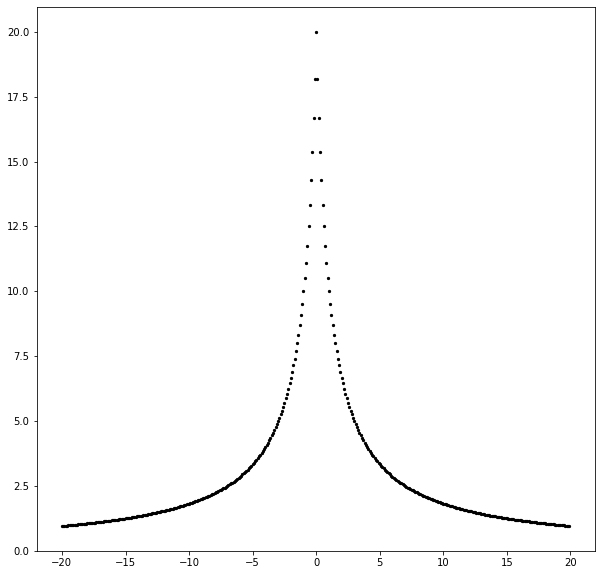

In [712]:
for sa in range(-2000, 2000, 10):
    sa = sa/100
    r = is_steering_angle_correct(sa)
    plt.scatter(sa, r, s = 5, c = 'k')
plt.show()

In [799]:
( 1 + 0.01 + 1 + 0 )**2 /100

0.04040099999999999